In [ ]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

import japanize_matplotlib
from fractions import Fraction

## 理想的な回路作成


In [ ]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

### 動作の確認
5量子ビットのアルゴリズムを実装し、動作を確認する。

初期状態$|0 \cdots 0\rangle$を作成

In [ ]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()
# print(state.get_vector())
# print(f'adf:{state.get_vector()[0]}')


次にアダマールゲートを作成する
$$
    H = \frac{1}{\sqrt(2)}(|0\rangle \langle 0| + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [ ]:

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

このアダマールゲートを初期状態$|0 \cdots 0\rangle$に作用させる。

$$
|s\rangle = (H \otimes \cdots \otimes H)|0 \cdots 0\rangle \\

= \frac{1}{(\sqrt{2})^n}(| 0 \rangle + | 1 \rangle) \otimes \cdots \otimes (| 0 \rangle + | 1 \rangle)\\

= \frac{1}{(\sqrt{2})^n} (|00 \cdots 00 \rangle + | 00 \cdots 01 \rangle + \cdots + | 11 \cdots 10\rangle + |11 \cdots 11 \rangle) \\

|s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0}^{2^n - 1} |x\rangle
$$

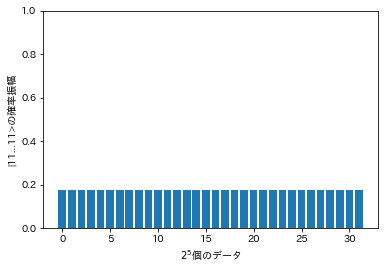

In [ ]:
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)
# print(f'初期：{state.get_vector()}')

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [ ]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [ ]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


print(fuga.get_vector())
最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [ ]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

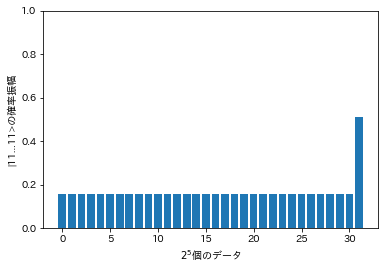

In [ ]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

In [ ]:
nqubits = 5

# グローバーのアルゴリズム
def grover(nqubits, operate_time):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


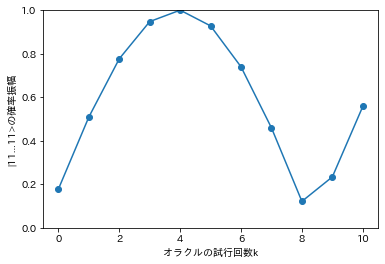

In [ ]:
grover(5, 10)

## ランダムな初期状態の作成
次に、ランダムな初期状態を作成する。

確率$p$でランダムな初期状態
$|\psi(p)\rangle = \sqrt{1 - p}|\psi_0\rangle + \sqrt{p}|\psi_{Haar}\rangle$
を作成する


In [ ]:
# 量子状態と複素数の積を利用して計算
nqubits = 5
p = 0.5
state1 = QuantumState(nqubits)
state2 = QuantumState(nqubits)
state1.set_zero_state()
state2.set_zero_state()
# psi_0, psi_Haar = state
psi_0 = state1
psi_Haar = state2

# Hadamard = make_Hadamard(nqubits)
# Hadamard.update_quantum_state(psi_0)
psi_0.set_zero_state()

psi_Haar.set_Haar_random_state()

# print(f'psi_0s norm: {psi_0.get_squared_norm()}, psi_Haars norm:{psi_Haar.get_squared_norm()}')

# (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
coef = np.sqrt(1 - p)
psi_0.multiply_coef(coef)
print(f'psi_0:{psi_0.get_squared_norm()}')

coef = np.sqrt(p)
psi_Haar.multiply_coef(coef)
print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

# (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
state = psi_0
state.add_state(psi_Haar)
print(f'state:{state.get_vector()}')
print(f'ノルム：{state.get_squared_norm()}')

psi_0:0.5000000000000001
psi_Haar: 0.49999999999999983
state:[ 0.77222477-0.19718411j  0.05985525+0.02094795j  0.11582222-0.07348378j
 -0.15204961-0.07138101j  0.17529604-0.02289175j -0.01466385+0.00352013j
 -0.03564811+0.08713739j  0.06157251-0.20244743j -0.07648447+0.18420213j
  0.10249424+0.0589765j  -0.11619387+0.12394945j -0.20857358-0.1396577j
  0.0855856 -0.08518028j  0.01321396+0.04708245j -0.02406822-0.097741j
 -0.10226252-0.07566751j  0.1234595 -0.06254336j  0.07798624-0.04038696j
 -0.05763921+0.0522755j   0.09442995+0.03016164j -0.01192875-0.02782328j
  0.1114678 -0.0628538j   0.05809791+0.08533632j -0.04925205+0.09072377j
 -0.03557392-0.07605666j -0.02100126-0.10032221j  0.0252374 +0.02401727j
 -0.01955268-0.10325502j -0.03355746-0.04095431j  0.02938526-0.0573505j
 -0.07987989+0.08395074j -0.01122602+0.01028596j]
ノルム：1.0920907387171135



先ほど作成した$|\psi(p)\rangle$を正規化する

$$
|\tilde{\psi}(p)\rangle = \frac{|\psi(p)\rangle}{\sqrt{\langle \psi(p)|\psi(p)\rangle}} \\
= \frac{\sqrt{1-p}|\psi_0\rangle + \sqrt{p}|\psi_{Haar}\rangle}{\sqrt{1 + \sqrt{p(1-p)}\langle \psi_0|\psi_{Haar}\rangle + \sqrt{p(1-p)}\langle \psi_0 | \psi_{Haar}\rangle}}
$$

In [ ]:
squared_norm = state.get_squared_norm()
print("sq_norm:", squared_norm)
state.normalize(squared_norm)
print("normalized:", state.get_vector())
print("sq_norm:", state.get_squared_norm())

sq_norm: 1.0920907387171135
normalized: [ 0.73894883-0.18868725j  0.05727603+0.02004528j  0.11083132-0.07031729j
 -0.14549764-0.06830513j  0.16774236-0.02190532j -0.01403197+0.00336844j
 -0.034112  +0.08338255j  0.05891929-0.19372377j -0.07318868+0.17626468j
  0.09807766+0.05643515j -0.11118696+0.11860834j -0.19958593-0.13363971j
  0.08189764-0.08150978j  0.01264455+0.04505362j -0.0230311 -0.09352924j
 -0.09785592-0.07240692j  0.1181395 -0.05984831j  0.07462573-0.03864664j
 -0.05515548+0.05002289j  0.09036086+0.02886194j -0.01141473-0.02662434j
  0.10666455-0.06014537j  0.05559442+0.0816591j  -0.04712973+0.08681439j
 -0.034041  -0.0727793j  -0.02009629-0.09599922j  0.0241499 +0.02298234j
 -0.01871014-0.09880565j -0.03211144-0.03918955j  0.02811902-0.05487921j
 -0.07643779+0.08033322j -0.01074228+0.00984273j]
sq_norm: 1.0


上記の関数化させたものが以下のCellである。

In [ ]:
# ランダムな初期状態を作成
def random_initial_state(nqubits, p):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()
    psi_Haar.set_Haar_random_state(0)

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - p)
    psi_0.multiply_coef(coef)
    coef = np.sqrt(p)
    psi_Haar.multiply_coef(coef)

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)
    return state

# ノルムを求める
def normalization(state):
    squared_norm = state.get_squared_norm()
    state.normalize(squared_norm)
    return state

In [ ]:
from qulacs import QuantumState
from qulacs.state import permutate_qubit, drop_qubit

ランダムな初期状態$|\tilde{\psi}(p)\rangle$にアダマールを作用させる。

$$
H|\tilde{\psi}(p)\rangle =
$$

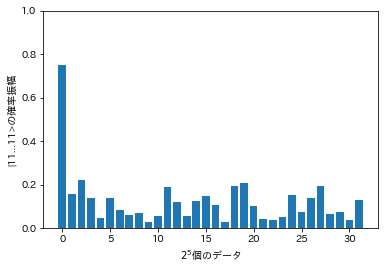

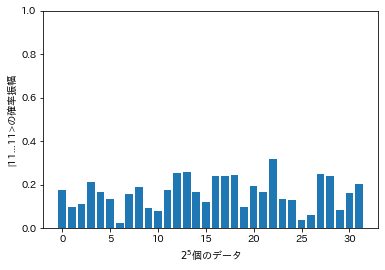

In [ ]:
nqubits = 5
p = 0.5
state = random_initial_state(nqubits, p)
state = normalization(state)
show_distribution(state, nqubits)
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)
show_distribution(state, nqubits)

In [ ]:
def noisy_grover(nqubits, operate_time, dephasing_rate):
    state = random_initial_state(nqubits, p)
    state = normalization(state)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    # state = QuantumState(nqubits)
    # state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")


In [ ]:
def noisy_grover_graph_output(nqubits, operate_time, dephasing_rate):
    state = random_initial_state(nqubits, p)
    state = normalization(state)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")

maximal probability 7.473493e-01 is obtained at k = 4


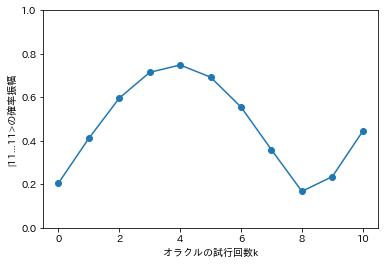

In [ ]:
max_result_k = []
noisy_grover(5, 10, 0.5)

### 確率の変更
確率pが0〜10まででどうのような動きをするのか調べる

maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4
maximal probability 7.473493e-01 is obtained at k = 4


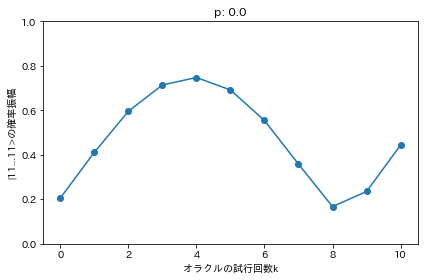

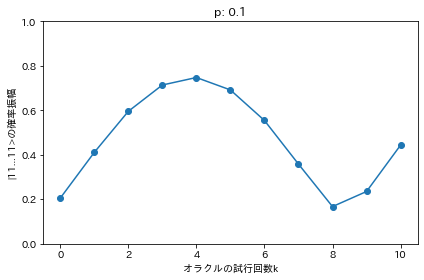

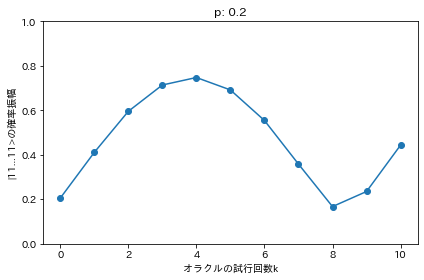

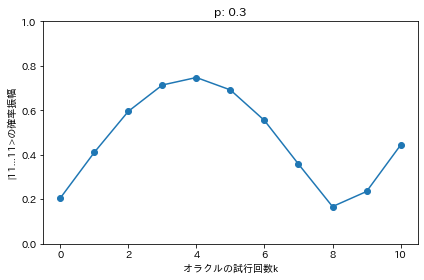

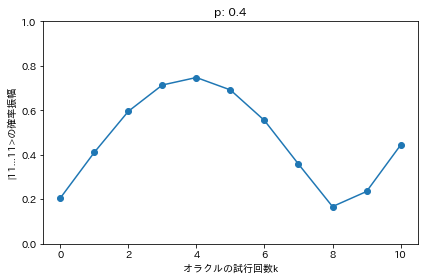

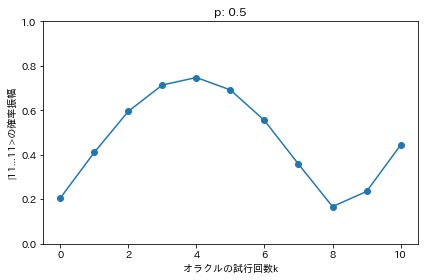

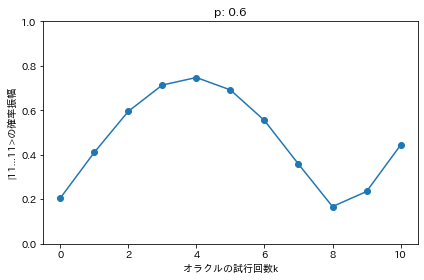

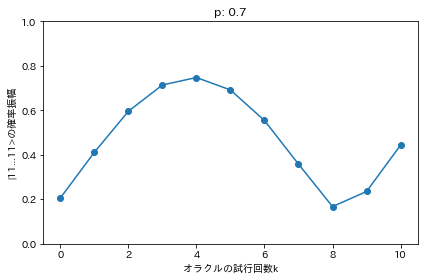

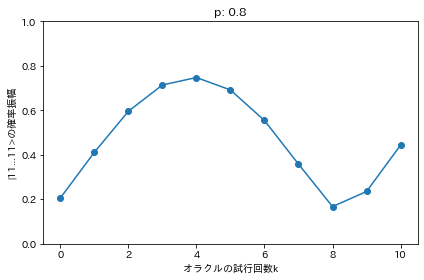

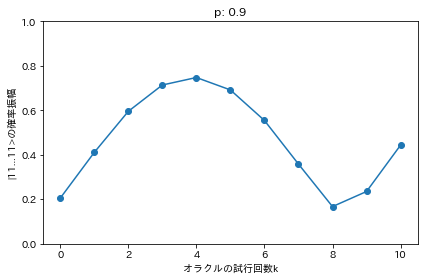

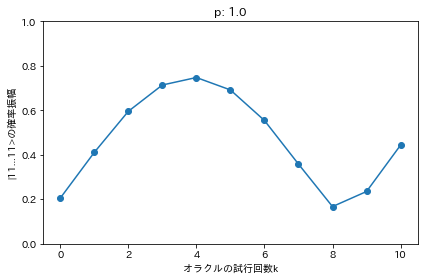

In [ ]:
max_result_k = []
times = 10
for i in range(times + 1):
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'p: {i / 10}')

    noisy_grover(5, 10, i / 10)

## 最大値に注目する(kに注目する)

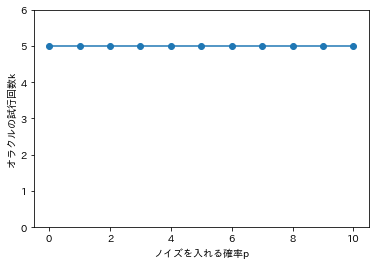

In [ ]:
plt.plot(max_result_k, "-o")
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.ylim(0, np.max(max_result_k) + 1)
plt.show()

 サンプルを増やして、グラフ化してみる

In [ ]:
max_result = []
nqubits = 5

for i in range(100):
    max_result_k = []
    for j in range(p + 1):
        noisy_grover_graph_output(nqubits, 10, j / 10)
    max_result.append(max_result_k)

# print(max_result)
for i in max_result:
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('オラクルの試行回数k')
    plt.plot(i, "-o")

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
hoge = []
for i in range(p + 1):
    fuga = []
    for j in range(100):
        fuga.append(max_result[j][i])
    hoge.append(fuga)


In [ ]:

plt.boxplot(hoge)
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.show()

In [ ]:
# 分散
var_array = []
for i in range(p + 1):
    v = np.var(hoge[i])
    var_array.append(v)
    print(f'分散：{v}')

plt.plot(var_array, "-o")
plt.title("分散")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

In [ ]:
# 標準偏差
std_array = []

for i in range(p + 1):
    std = np.std(hoge[i])
    std_array.append(std)
    print(f'標準偏差:{std}')

plt.plot(std_array, "-o")
plt.title("標準偏差")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

## k = 4の時に注目する

In [ ]:
k_array = []
def noisy_grover_graph_output_k(nqubits, operate_time, dephasing_rate, k):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(result)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    # max_k = np.argmax(result)
    k_array.append(result[3])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")


In [ ]:
nqubits = 5
k = 4
k_array = []
for i in range(p + 1):
    noisy_grover_graph_output_k(nqubits, 10, i / 10, k)

print(k_array)

In [ ]:
max_result = []
nqubits = 5
k = 4

for i in range(100):
    k_array = []
    for j in range(p + 1):
        noisy_grover_graph_output_k(nqubits, 10, j / 10, k)
    max_result.append(k_array)

# print(max_result)
for i in max_result:
    plt.plot(i)
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('|11...11>の確率振幅')

